# Imports
### General imports

In [28]:
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd
from pathlib import Path

### Regressors imports

In [29]:
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import RidgeCV as Ridge
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import RadiusNeighborsRegressor as radNN
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as Ada
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as ANN

In [30]:
reg = {'LM':LM(),
#      'Ridge':Ridge(),
      'KNN':KNN(),
#      'radNN':radNN(radius=200),
      'DT':DT(random_state=42),
      'RF':RF(random_state=42),
      'ET':ET(n_estimators=100,random_state=42), #random_state=0
#      'Ada':Ada(),
#      'SVM':SVR(),
      'ANN':ANN(max_iter=400,random_state=42) #hidden_layer_sizes=(50,),max_iter=400
      } #shuffle=False,

### Assesment metrics

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

from wikipedia:
There are cases where the computational definition of R2 can yield negative values, depending on the definition used. This can arise when the predictions that are being compared to the corresponding outcomes have not been derived from a model-fitting procedure using those data. Even if a model-fitting procedure has been used, R2 may still be negative, for example when linear regression is conducted without including an intercept,[5] or when a non-linear function is used to fit the data.[6] **In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion**.

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Data Loading

In [33]:
DEBUG = False
#DEBUG = True

In [34]:
tsla_price_path = Path("../data/data_h_corrected.pickle")
tsla_trend_path = Path("../data/GT_tsla_h.pickle")
musk_trend_path = Path("../data/GT_musk_h.pickle")
#musk_twitter_path = Path("../data/twitter_musk_h.pickle")
musk_tesla_twitter_path = Path("../data/twitter_musk_tesla_h.pickle")

if DEBUG:
    print(tsla_price_path + '\n')
    print(tsla_trend_path + '\n')
    print(musk_trend_path + '\n')
#    print(musk_twitter_path + '\n')
    print(musk_tesla_twitter_path + '\n')

tsla_price = pickle.load(open(tsla_price_path,"rb"))['Open']
tsla_trend = pickle.load(open(tsla_trend_path,"rb"))
musk_trend = pickle.load(open(musk_trend_path,"rb"))
#musk_twitter = pickle.load(open(musk_twitter_path,"rb"))
musk_tesla_twitter = pickle.load(open(musk_tesla_twitter_path,"rb"))

In [35]:
#print(type(musk_twitter.index))
print(type(musk_tesla_twitter.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [36]:
start_ts = tsla_price.index[0]
end_ts = tsla_price.index[-1]
tsla_trend = tsla_trend[start_ts:end_ts]
musk_trend = musk_trend[start_ts:end_ts]
#musk_twitter = musk_twitter[start_ts:end_ts]
musk_tesla_twitter = musk_tesla_twitter[start_ts:end_ts]
data = pd.concat([tsla_price,tsla_trend,musk_trend,musk_tesla_twitter],axis=1)
#need to replace NAN in the musk_tesla_twitter columns with zero, or the later step of removing NAN rows will delete stuff I don't want
#to delete. This is because I didn't preprocess the musk_tesla_twitter data the same way as the musk_twitter
data[["like_count","retweet_count","reply_count","quote_count"]] = data[["like_count","retweet_count","reply_count","quote_count"]].fillna(0)
#print(data.head(10))

Note to self: there are only 7 hours of prices every working day, whereas there is trend data for every hour of every day... I should keep this in mind, and be wary as it might cause a problem later...

# Cut date for training/test set

In [37]:
cut_date = dt.datetime(year=2021,month=1,day=4,hour=16) # For now just testing various cut point around 2 month
print('cut date = ',cut_date)
#print(pd.Timestamp(cut_date))
#cut_idx = tsla_price.index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
#print('cut index = ',cut_idx)

cut date =  2021-01-04 16:00:00


# Auxilary functions
### Split data

In [38]:
def split_data(data,cut_idx):
    train = data[:cut_idx]
    test = data[cut_idx:]
    return train, test

### Converting from original to log returns and back functions

In [39]:
def convert_to_logret(stock_price):
    initial = stock_price.iloc[0]
    returns = 100*(np.log(stock_price)).diff()
    return returns, initial

def convert_from_logret(returns,initial,axis=0):
    stock_price = np.exp((returns/100).cumsum(axis)) * initial
    return stock_price

### Plot Prediction function

In [40]:
def plot_predict(stock_train,stock_test,stock_predict):
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    axs[0].plot(stock_train)
    axs[0].plot(stock_test)
    axs[0].plot(stock_predict)

    axs[1].plot(stock_train[-300:])
    axs[1].plot(stock_test)
    axs[1].plot(stock_predict)
    return


#y_test_true = response[cut_idx:-35*4]
#x_test = features[cut_idx:-35*4]
#y_test = dectree_v2.predict(x_test)

#y_train_os = np.exp((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0]))
#offset = ((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0])).iloc[-1,0]
#print(np.exp(offset))
#y_test_os = np.exp((y_test/100).cumsum(1)+offset)
#y_test_true_os = np.exp((y_test_true/100).cumsum(1)+offset)



# Features and responses

In [41]:
time = pd.Series(data=range(len(tsla_trend)),index=tsla_trend.index)
data['time'] = time
returns, initial = convert_to_logret(tsla_price)
data['returns'] = returns
#print(data.head(20))
data.dropna(inplace=True)
#print(data.head(20))

# price shifting

In [42]:
def shift(df,column,list_shifts):
    for i in list_shifts:
        name = column + str(-i)
        df[name]=df[column].shift(i)
    return df

In [43]:
print(data.head())

                          Open  tsla  musk  like_count  retweet_count  \
2019-02-11 17:00:00  63.153004  7.65  4.62         0.0            0.0   
2019-02-11 18:00:00  62.935997  7.74   4.9         0.0            0.0   
2019-02-11 19:00:00  63.230000  7.74  5.04         0.0            0.0   
2019-02-11 20:00:00  62.996002  7.92  5.53         0.0            0.0   
2019-02-11 21:00:00  62.826836  7.83  5.32         0.0            0.0   

                     reply_count  quote_count  time   returns  
2019-02-11 17:00:00          0.0          0.0     1  1.279676  
2019-02-11 18:00:00          0.0          0.0     2 -0.344212  
2019-02-11 19:00:00          0.0          0.0     3  0.466058  
2019-02-11 20:00:00          0.0          0.0     4 -0.370760  
2019-02-11 21:00:00          0.0          0.0     5 -0.268897  


In [44]:
f_list = ['tsla','musk','time','retweet_count','like_count'] #'tsla','musk','time','retweet_count','like_count'
#f_list2 = f_list + ['returns'+str(i) for i in range(-35*4,0)]
features = data[f_list]
#features2 = data[f_list2]
response = data[['returns']]
#response2 = data[['returns']+['returns'+str(i) for i in range(1,35*4)]]
#print(features2)
#print(response2)

# training

In [45]:
#cut_idx = tsla_price.reset_index().index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
cut_idx = pd.Timestamp(cut_date)
#print('cut index = ',cut_idx)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(response,cut_idx)
#x2_train, x2_test = split_data(features2,cut_idx)
#y2_train, y2_test = split_data(response2,cut_idx)
#x2_train = x2_train[:-35*4]
#y2_train = y2_train[:-35*4]

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

In [46]:
#Scaler
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train,y_train)

metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

# fitting the models

In [47]:
#reg['LM'].fit(x_train,y_train)
for model in reg:
    reg[model].fit(x_train_minmax,y_train['returns'])

# Prediction

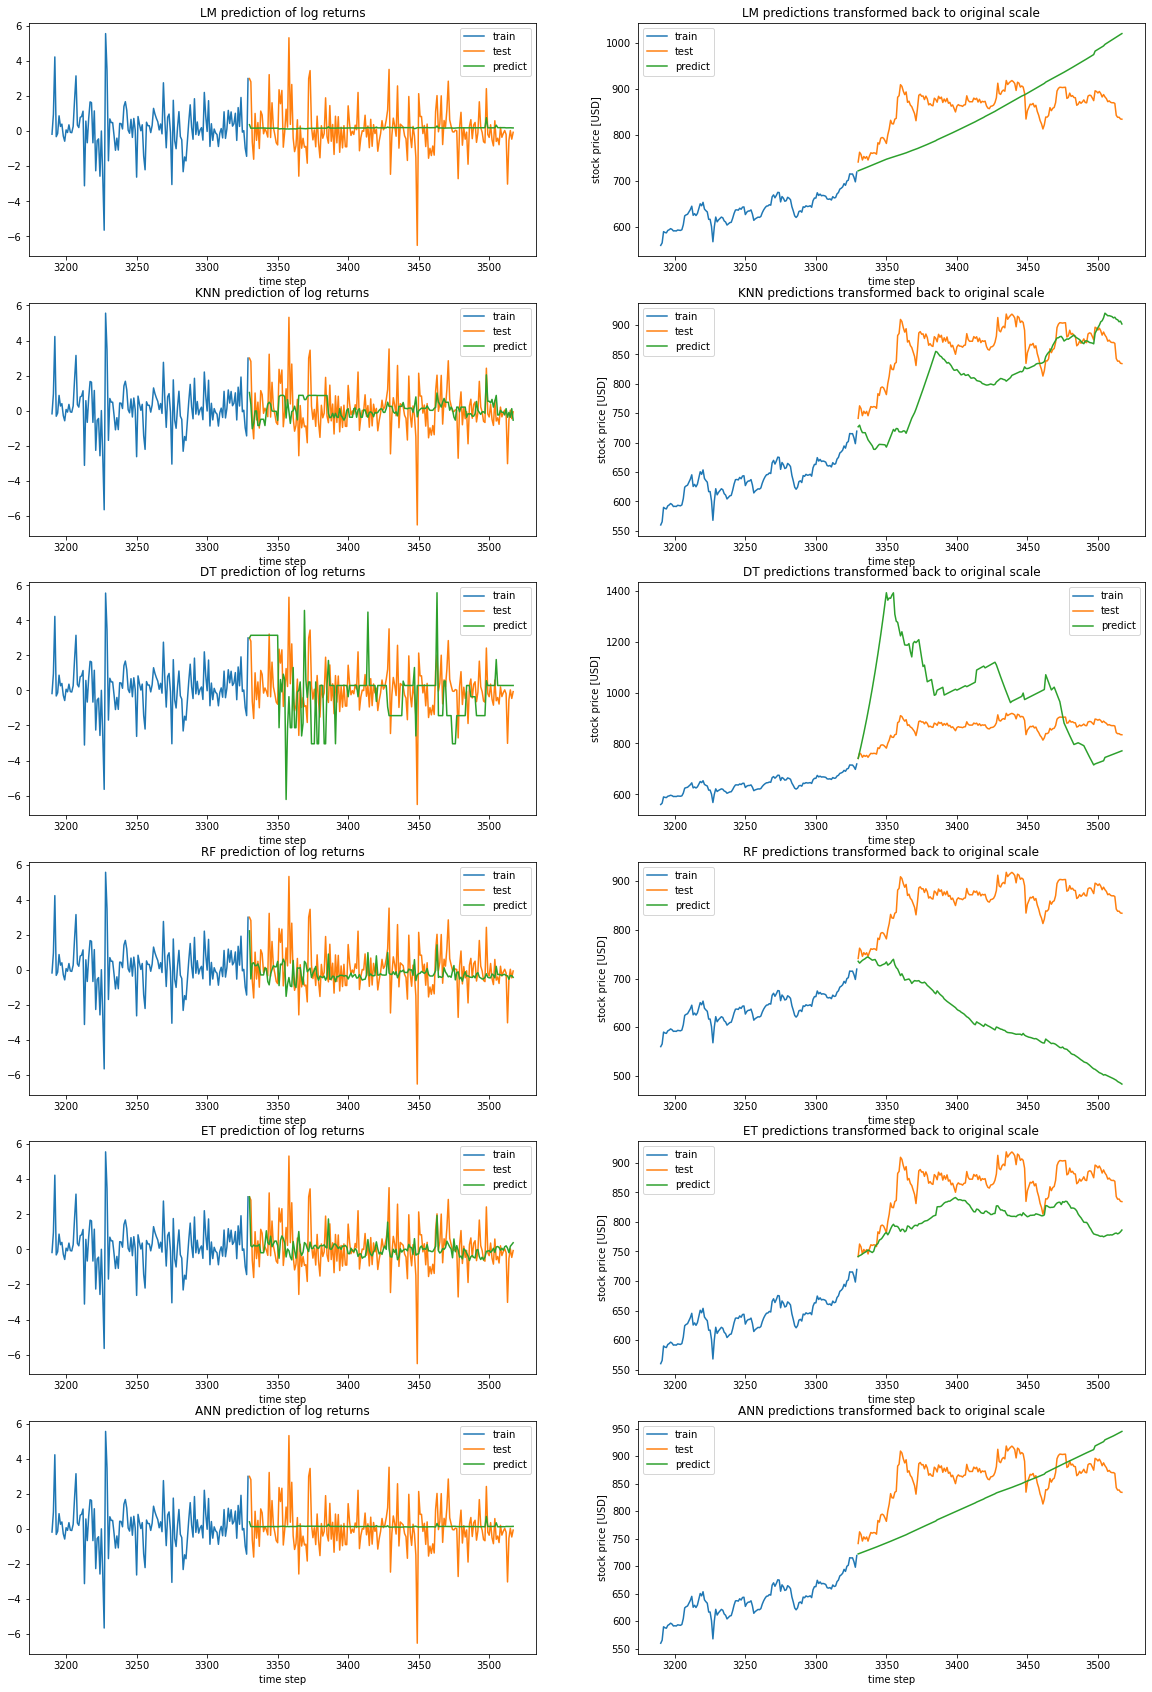

In [48]:
fig, axs =plt.subplots(len(reg),2,figsize=(20,5*len(reg)))
i = 0

for model in reg:
    #print(model)
    y_predict = reg[model].predict(scaler.transform(x_test))
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    y_train_os = convert_from_logret(y_train,initial,axis=0)
    y_test_os = convert_from_logret(y_test,data.loc[cut_idx,'Open'],axis=0)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=0)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os,y_predict_os)
    
    n_train = len(y_train)
    n_test = len(y_test_os)
    
    axs[i,0].plot(range(n_train-35*4,n_train),y_train.iloc[-35*4:])
    axs[i,0].plot(range(n_train,n_train+n_test),y_test)
    axs[i,0].plot(range(n_train,n_train+n_test),y_predict[0])
    
    axs[i,0].legend(['train','test','predict'])
    axs[i,0].set_title(model + ' prediction of log returns')
    axs[i,0].set_xlabel("time step")

    axs[i,1].plot(range(n_train-35*4,n_train),y_train_os.iloc[-35*4:])
    axs[i,1].plot(range(n_train,n_train+n_test),y_test_os)
    axs[i,1].plot(range(n_train,n_train+n_test),y_predict_os[0])

    axs[i,1].legend(['train','test','predict'])
    axs[i,1].set_title(model + ' predictions transformed back to original scale')
    axs[i,1].set_xlabel("time step")
    axs[i,1].set_ylabel("stock price [USD]")
    
    
    
    metrics["MSE"][model] = mean_squared_error(y_test, y_predict)
    metrics["R2"][model] = r2_score(y_test,y_predict)
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os, y_predict_os)
    metrics["R2_original_scale"][model] = r2_score(y_test_os,y_predict_os)
    
    i=i+1

img_mlresults_basic = "../report/img/img_mlresults_basic.pdf"
plt.savefig(img_mlresults_basic,bbox_inches="tight")
plt.show()

# Assesment

In [49]:
#from pandas.plotting import table 

In [50]:
#print("mean square error : ",mean_squared_error(y_test, y_predict))
#print("R2 : ",r2_score(y_test,y_predict))

print(metrics)
#ax = plt.subplot(111, frame_on=False)
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)  # hide the y axis

#table(ax,metrics)
#tab_mlresults_basic = "../report/img/tab_mlresults_basic.pdf"
#plt.savefig(tab_mlresults_basic,bbox_inches="tight")
tab_mlresults_basic = "../report/tab/tab_mlresults_basic.tex"

metrics.to_latex(tab_mlresults_basic,caption="Error measures of the univariate response case, on the log returns scale and original scale",label="tab:mlresults_basic")

          MSE        R2 MSE_original_scale R2_original_scale
LM   1.664561 -0.000341        5960.578628          -2.63797
KNN  1.688098 -0.014486        4961.628022         -2.028272
DT   4.651385 -1.795314       48679.688708        -28.711082
RF   1.891906 -0.136967       70527.596032        -42.045699
ET   1.736647 -0.043662        4290.087136         -1.618405
ANN   1.64744  0.009948        4225.592221         -1.579041


# Using one month to predict one week ahead

In [51]:
data = shift(data,'returns',range(-35*4+1,35*4+1))
data = shift(data,'tsla',range(1,35*4+1))
data = shift(data,'musk',range(1,35*4+1))
data = shift(data,'like_count',range(1,35*4+1))
data = shift(data,'retweet_count',range(1,35*4+1))
data = data.dropna()

In [52]:
forward_timesteps = 35 #one week
backward_timesteps = -35*4 #four weeks

stock_variables = ["returns"]+['returns'+str(i) for i in range(backward_timesteps,0)]
g_trend_variables = ["tsla","musk"]+['tsla'+str(i) for i in range(backward_timesteps,0)]#+['musk'+str(i) for i in range(backward_timesteps,0)]
twitter_variables = [] + ["retweet_count"]+['retweet_count'+str(i) for i in range(backward_timesteps,0)]#+ ["like_count"]+['like_count'+str(i) for i in range(backward_timesteps,0)]

feature_list = stock_variables + g_trend_variables + twitter_variables + ["time"]
response_list = ["returns"]+['returns'+str(i) for i in range(1,forward_timesteps)]

features = data[feature_list]
responses = data[response_list]

cut_idx = pd.Timestamp(cut_date)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(responses,cut_idx)

#correction for overlapping features and responses:
x_train = x_train[:-forward_timesteps]
y_train = y_train[:-forward_timesteps]
    
#Scaler
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train,y_train)
    
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

In [53]:
for model in reg:
    reg[model].fit(x_train_minmax,y_train)

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


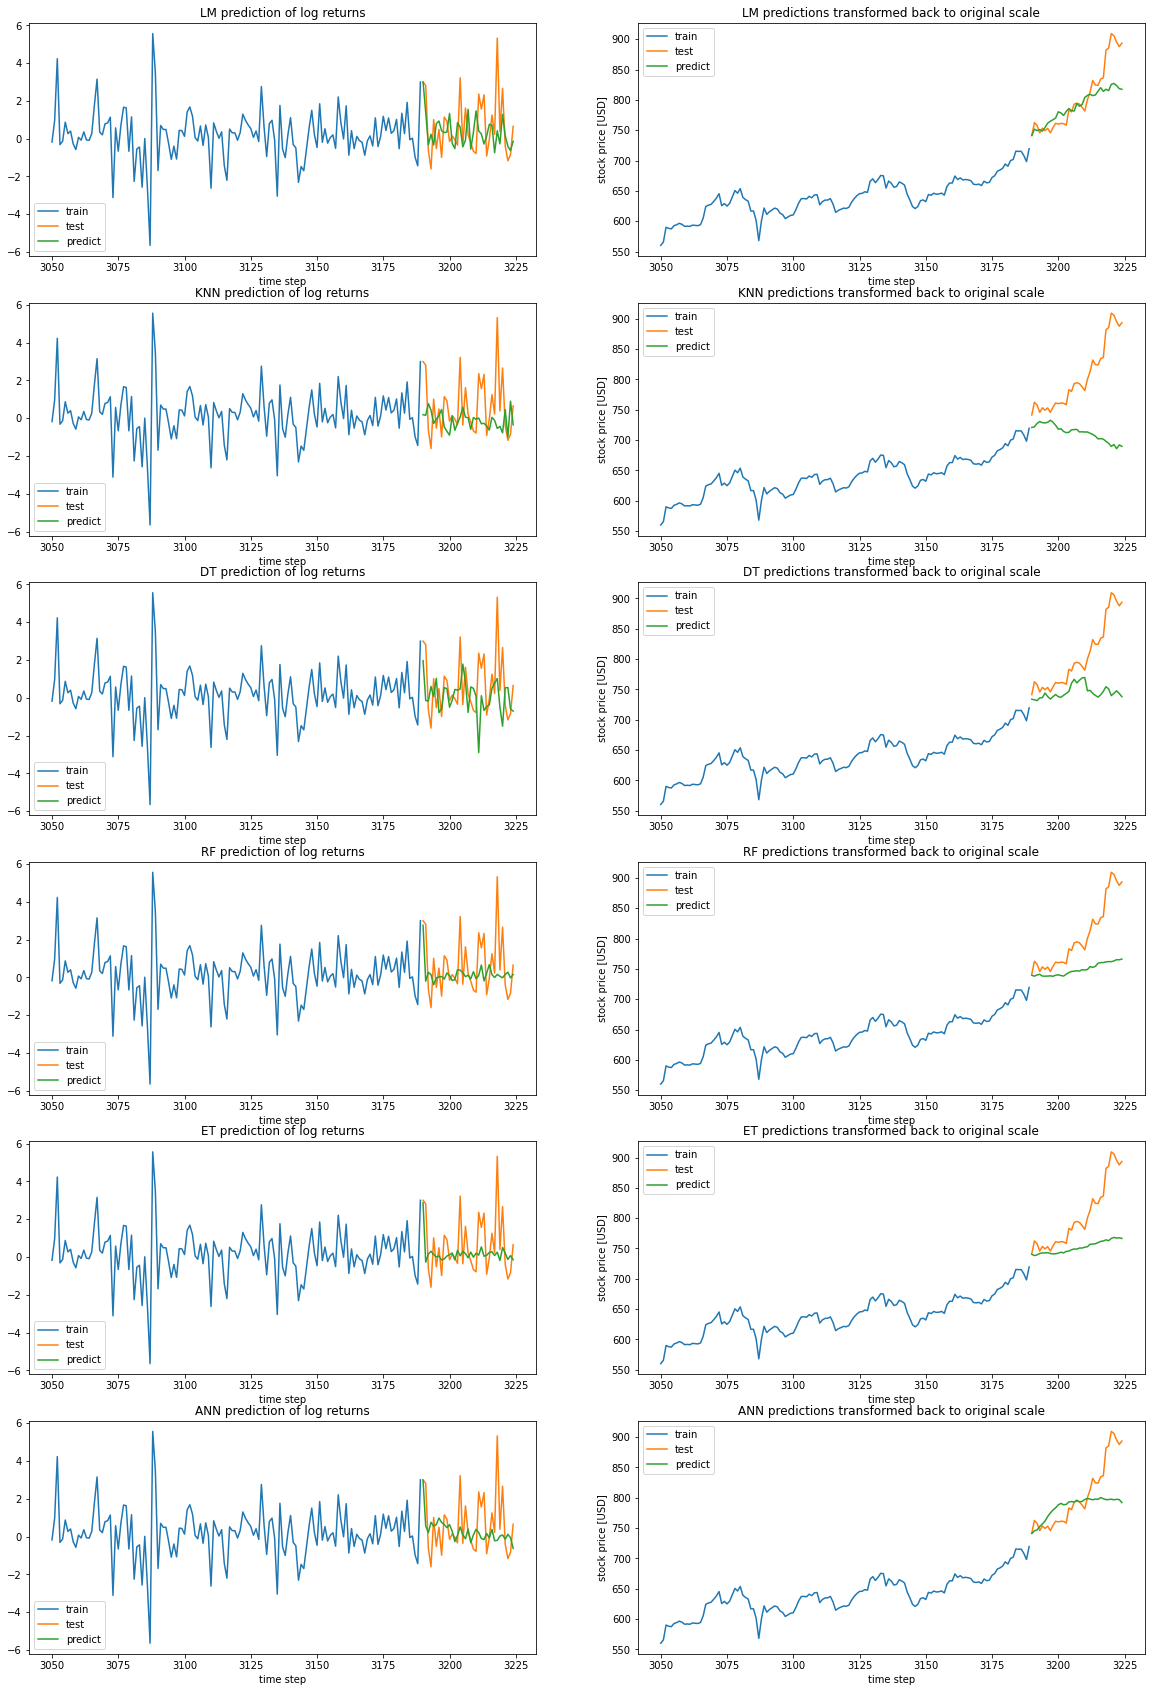

In [54]:
fig, axs =plt.subplots(len(reg),2,figsize=(20,5*len(reg)))
i = 0

for model in reg:
    y_predict = reg[model].predict(scaler.transform(x_test))
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    
    #we need the initial stock price to transforme the returns back into the real price
    iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
    #change the returns back to the price (os=original scale)
    y_train_os = convert_from_logret(y_train,initial)
    y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
    
    
    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y_test_os.iloc[0])
    #print(n_train, n_test, backward_timesteps)

    axs[i,0].plot(range(n_train+backward_timesteps,n_train),data['returns'][:cut_idx][backward_timesteps:])
    axs[i,0].plot(range(n_train,n_train+n_test),y_test.iloc[0])
    axs[i,0].plot(range(n_train,n_train+n_test),y_predict.iloc[0])
    
    axs[i,0].legend(['train','test','predict'])
    axs[i,0].set_title(model + ' prediction of log returns')
    axs[i,0].set_xlabel("time step")

    axs[i,1].plot(range(n_train+backward_timesteps,n_train),data['Open'][:cut_idx][backward_timesteps:])
    axs[i,1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
    axs[i,1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

    axs[i,1].legend(['train','test','predict'])
    axs[i,1].set_title(model + ' predictions transformed back to original scale')
    axs[i,1].set_xlabel("time step")
    axs[i,1].set_ylabel("stock price [USD]")
    
    
    metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
    metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
    i=i+1

img_mlresults_v2 = "../report/img/img_mlresults_v2.pdf"
plt.savefig(img_mlresults_v2,bbox_inches="tight")
plt.show()


In [55]:
print(metrics)

tab_mlresults_v2 = "../report/tab/tab_mlresults_v2.tex"

metrics.to_latex(tab_mlresults_v2,caption="Error measures of the multivariate response case, on the log returns scale and original scale",label="tab:mlresults_v2")

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.207717   0.03016        1221.188237           0.56383
KNN  3.289516 -0.445069       12481.958896         -3.458159
DT   3.432398 -0.507836        6071.715611         -1.168624
RF   2.405434 -0.056696        4820.029744         -0.721561
ET   2.282087  -0.00251        4538.482434         -0.621002
ANN  2.488183 -0.093047        2284.406514          0.184083
